# **Feature Selection**

In [ ]:
import librosa
import os
import librosa.display
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Loading Data**

In [ ]:

file_path = "/content/drive/MyDrive/UrbanSound8K/metadata/UrbanSound8K.csv"

urban_sound = pd.read_csv(file_path)
urban_sound

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


## Label Encoding

In [ ]:
# Directory where the audio folders are stored
input_path = "/content/drive/MyDrive/UrbanSound8K/audio"

for number_fold in range(1, 11):
    fold_x_data = urban_sound[urban_sound['fold'] == number_fold]
    one_hot_labels = pd.get_dummies(urban_sound['classID'], prefix='classID')

    original_fold_path = os.path.join(input_path, f'fold{number_fold}_4sec')

    contador = 0

    # Iterate over each row in the filtered DataFrame
    for index, row in fold_x_data.iterrows():
        # Extract the file name without '.wav' extension
        file_name = row['slice_file_name'].replace('.wav', '')

        # Define the full path for the audio file
        audio_file_path = os.path.join(original_fold_path, f"{file_name}.wav")

        # Check if the audio file exists in the original fold path
        if os.path.exists(audio_file_path):
            contador += 1
            # Retrieve the one-hot encoded label for this row
            label = one_hot_labels.iloc[index].values

            output_path = os.path.join(input_path, f"fold{number_fold}_label")
            os.makedirs(output_path, exist_ok=True)

            # Define the full path for the .npy file
            label_file_path = os.path.join(output_path, f"{file_name}_label.npy")

            # Save the label to a .npy file
            np.save(label_file_path, label)
            print(f"label saved at {label_file_path}")


Streaming output truncated to the last 5000 lines.
label saved at /content/drive/MyDrive/UrbanSound8K/audio/fold5_label/104998-7-10-8_label.npy
label saved at /content/drive/MyDrive/UrbanSound8K/audio/fold5_label/104998-7-10-9_label.npy
label saved at /content/drive/MyDrive/UrbanSound8K/audio/fold5_label/104998-7-11-0_label.npy
label saved at /content/drive/MyDrive/UrbanSound8K/audio/fold5_label/104998-7-11-2_label.npy
label saved at /content/drive/MyDrive/UrbanSound8K/audio/fold5_label/104998-7-12-2_label.npy
label saved at /content/drive/MyDrive/UrbanSound8K/audio/fold5_label/104998-7-14-1_label.npy
label saved at /content/drive/MyDrive/UrbanSound8K/audio/fold5_label/104998-7-14-5_label.npy
label saved at /content/drive/MyDrive/UrbanSound8K/audio/fold5_label/104998-7-14-6_label.npy
label saved at /content/drive/MyDrive/UrbanSound8K/audio/fold5_label/104998-7-15-1_label.npy
label saved at /content/drive/MyDrive/UrbanSound8K/audio/fold5_label/104998-7-15-3_label.npy
label saved at /con

## 3D Array Creation

### Verify if the order of the files is homogeneous


#### Verification of the lenght

In [ ]:
input_path = "/content/drive/MyDrive/UrbanSound8K/audio"

def count_visible_and_hidden_files(directory):
    # Lista todos os arquivos no diretório, incluindo arquivos ocultos
    all_files = os.listdir(directory)

    # Filtra apenas os arquivos não ocultos
    visible_files = [f for f in all_files if not f.startswith('.')]

    # Filtra apenas os arquivos ocultos
    hidden_files = [f for f in all_files if f.startswith('.')]

    return len(visible_files), len(hidden_files)



# Loop from 1 to 10 (inclusive)
for i in range(1, 11):
    # Construct the directory names
    dir_mfccs_25 = os.path.join(input_path, f'fold{i}_4sec_mfccs_25')
    dir_mfccs_13 = os.path.join(input_path, f'fold{i}_4sec_mfccs_13')
    dir_labels = os.path.join(input_path, f'fold{i}_label')

    # Get the length (number of files) for each directory
    length_mfccs_25 = len(os.listdir(dir_mfccs_25)) if os.path.exists(dir_mfccs_25) else 0
    length_mfccs_13 = len(os.listdir(dir_mfccs_13)) if os.path.exists(dir_mfccs_13) else 0
    length_labels = len(os.listdir(dir_labels)) if os.path.exists(dir_labels) else 0

    # Print out the lengths
    print(f"Number of files in {dir_mfccs_25}: {length_mfccs_25}")
    print(f"Number of files in {dir_mfccs_13}: {length_mfccs_13}")
    print(f"Number of files in {dir_labels}: {length_labels}")


Number of files in /content/drive/MyDrive/UrbanSound8K/audio/fold1_4sec_mfccs_25: 893
Number of files in /content/drive/MyDrive/UrbanSound8K/audio/fold1_4sec_mfccs_13: 893
Number of files in /content/drive/MyDrive/UrbanSound8K/audio/fold1_label: 873
Number of files in /content/drive/MyDrive/UrbanSound8K/audio/fold2_4sec_mfccs_25: 908
Number of files in /content/drive/MyDrive/UrbanSound8K/audio/fold2_4sec_mfccs_13: 908
Number of files in /content/drive/MyDrive/UrbanSound8K/audio/fold2_label: 888
Number of files in /content/drive/MyDrive/UrbanSound8K/audio/fold3_4sec_mfccs_25: 925
Number of files in /content/drive/MyDrive/UrbanSound8K/audio/fold3_4sec_mfccs_13: 925
Number of files in /content/drive/MyDrive/UrbanSound8K/audio/fold3_label: 925
Number of files in /content/drive/MyDrive/UrbanSound8K/audio/fold4_4sec_mfccs_25: 990
Number of files in /content/drive/MyDrive/UrbanSound8K/audio/fold4_4sec_mfccs_13: 990
Number of files in /content/drive/MyDrive/UrbanSound8K/audio/fold4_label: 990


#### Verification of the order of the files

In [ ]:

input_path = "/content/drive/MyDrive/UrbanSound8K/audio"

for i in range(1, 11):
    folder_path_labels = os.path.join(input_path, f"fold{i}_label")
    folder_path_mfccs_13 = os.path.join(input_path, f'fold{i}_4sec_mfccs_13')
    folder_path_mfccs_25 = os.path.join(input_path, f'fold{i}_4sec_mfccs_25')

    label_names = []
    mfccs_names_13 = []
    mfccs_names_25 = []

    if os.path.exists(folder_path_labels):
        for file in os.listdir(folder_path_labels):
            name = file.replace('_label.npy', '')
            label_names.append(name)

    if os.path.exists(folder_path_mfccs_13):
        for file in os.listdir(folder_path_mfccs_13):
            name = file.replace('_mfcc13.npy', '')
            mfccs_names_13.append(name)

    if os.path.exists(folder_path_mfccs_25):
        for file in os.listdir(folder_path_mfccs_25):
            name = file.replace('_mfcc25.npy', '')
            mfccs_names_25.append(name)

    # Comparing the three lists - print true if all are equal
    if set(label_names) == set(mfccs_names_13) == set(mfccs_names_25):
        print(f"All lists for fold{i} are equal: True")
    else:
        print(f"All lists for fold{i} are equal: False")


All lists for fold1 are equal: False
All lists for fold2 are equal: False
All lists for fold3 are equal: True
All lists for fold4 are equal: True
All lists for fold5 are equal: True
All lists for fold6 are equal: True
All lists for fold7 are equal: True
All lists for fold8 are equal: True
All lists for fold9 are equal: True
All lists for fold10 are equal: True


### Creation of three 3D arrays per fold: mfccs (13 and 25) arrays and labels array

#### The sizes of the arrays are: (10,1,number of files of the folder), (13, 751, number of files of the folder) and (25, 751, number of files of the folder) and

##### The order of the files are the same in both arrays;
###### Example: mfcc[1] and labels[1] correspond to audio 1.

In [ ]:
def create_3d(folder_path):


    arrays_list = []  #to store the 2D arrays
    reference_shape = None  #keep track of the shape of the first array loaded

    for file_name in sorted(os.listdir(folder_path)):


        if "3D_array.npy" in file_name:
          #to avoid including an existing 3D array
            continue


        file_path = os.path.join(folder_path, file_name)
        array = np.load(file_path, allow_pickle=True)


        if reference_shape is None:
          #which is only true for the first file
            reference_shape = array.shape #sets to the shape of the loaded array


        elif array.shape != reference_shape:

            print(f"Shape mismatch in file: {file_name}, expected {reference_shape}, got {array.shape}")
            continue  # Skip files that don't match the reference shape

        if len(array.shape) == 1:  # Para o caso de arrays terminados em _label
            array = array.reshape((array.shape[0], 1))  # Adiciona uma dimensão extra


        arrays_list.append(array)


    if arrays_list:

        # if is not empty
        #stacks all arrays along the last axis (axis=-1) to create a 3D array.
        array_3d = np.stack(arrays_list, axis=-1)
        return array_3d

    else:

        return None  # Return None if no arrays were added to the list


In [ ]:
#Catarina's path
input_path = "/content/drive/MyDrive/UrbanSound8K/audio"

#Lara's path
# input_path = "/content/drive/MyDrive/ACII/UrbanSound8K/audio"

# Array of folders to be analyzed
folders_to_analyze_label = [folder for folder in os.listdir(input_path) if folder.endswith("_label")]
folders_to_analyze_label.sort()  # Order the folders


for i in range(1, 11):

    for suffix in ["_label", "_4sec_mfccs_13", "_4sec_mfccs_25"]:
        folder_name = f"fold{i}{suffix}"
        folder_path = os.path.join(input_path, folder_name)

        if os.path.isdir(folder_path):

          array_3d = create_3d(folder_path)
          # Save the 3D array to a .npy file
          output_path = os.path.join(folder_path, "3D_array.npy")
          np.save(output_path, array_3d)

          print(f"3D array of {folder_name}: saved")



3D array of fold1_label: saved
3D array of fold1_4sec_mfccs_13: saved
3D array of fold1_4sec_mfccs_25: saved
3D array of fold2_label: saved
3D array of fold2_4sec_mfccs_13: saved
3D array of fold2_4sec_mfccs_25: saved
3D array of fold3_label: saved
3D array of fold3_4sec_mfccs_13: saved
3D array of fold3_4sec_mfccs_25: saved
3D array of fold4_label: saved
3D array of fold4_4sec_mfccs_13: saved
3D array of fold4_4sec_mfccs_25: saved
3D array of fold5_label: saved
3D array of fold5_4sec_mfccs_13: saved
3D array of fold5_4sec_mfccs_25: saved
3D array of fold6_label: saved
3D array of fold6_4sec_mfccs_13: saved
3D array of fold6_4sec_mfccs_25: saved
3D array of fold7_label: saved
3D array of fold7_4sec_mfccs_13: saved
3D array of fold7_4sec_mfccs_25: saved
3D array of fold8_label: saved
3D array of fold8_4sec_mfccs_13: saved
3D array of fold8_4sec_mfccs_25: saved
3D array of fold9_label: saved
3D array of fold9_4sec_mfccs_13: saved
3D array of fold9_4sec_mfccs_25: saved
3D array of fold10_

### 3D Arrays Representation

In [ ]:
def plot_3d_array_subset(array_3d, num_slices=10):

    # Calculate the number of slices to skip to get only 'num_slices' slices
    total_slices = array_3d.shape[2]

    #for stepping over slices
    step = max(1, total_slices // num_slices)

    #sets up a matplotlib figure and a set of subplots with one row and num_slices columns
    fig, axes = plt.subplots(1, num_slices, figsize=(20, 10))

    # Plot each slice in a subplot
    for i, idx in enumerate(range(0, total_slices, step)):

        if i >= num_slices:
          # Prevent creating more subplots than num_slices
            break

        ax = axes[i]  #selects the appropriate subplot axis from the axes array using i
        slice_2d = array_3d[:, :, idx]  #retrieves the 2D slice from the 3D array using the current index idx
        cax = ax.matshow(slice_2d, interpolation='nearest')
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'Slice {idx + 1}')

    plt.tight_layout()
    plt.show()


###### Used the last "array_3d" created on the previous block of code, which means, this graph is refered to fold10_resampled_mfccs_25

In [ ]:
array_3d.shape

(25, 751, 837)

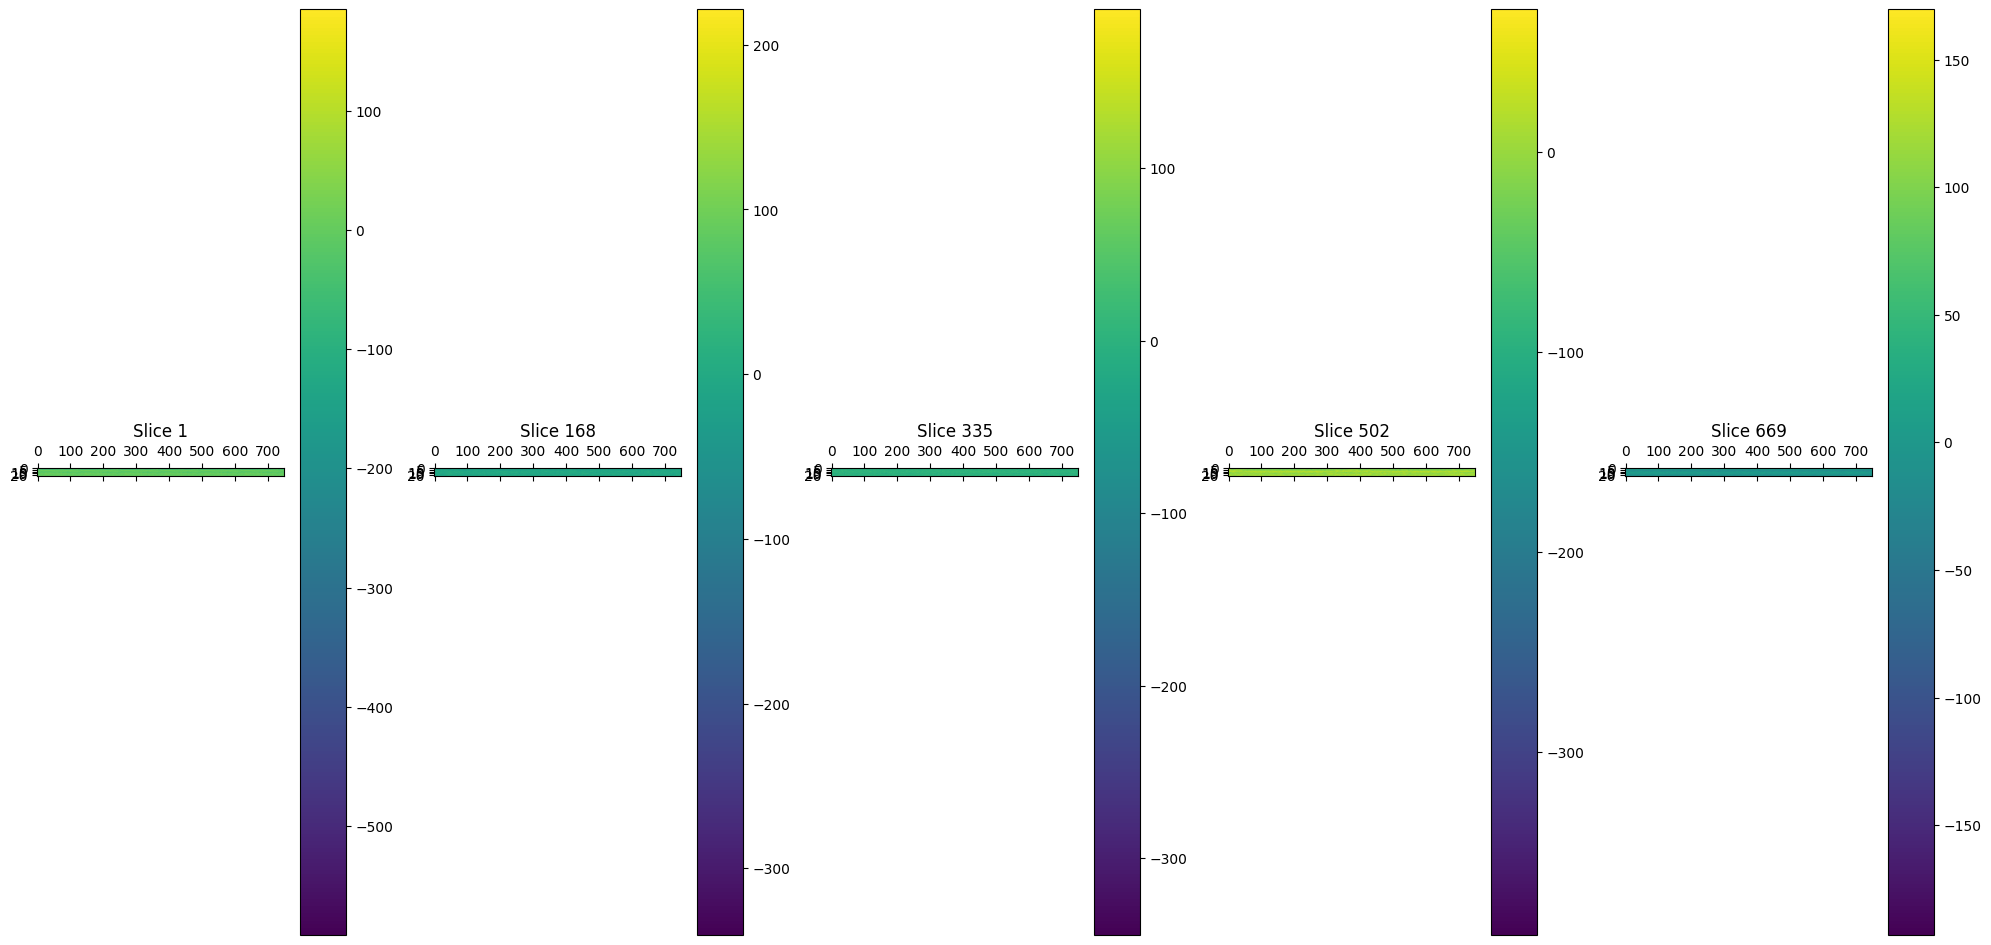

In [ ]:
plot_3d_array_subset(array_3d, num_slices=5)